In [2]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm

In [179]:
@njit
def init_arrays(N):
    U = np.ones((N, N))#np.random.rand(N, N)
    V = np.zeros((N, N))
    V[N//2-10 : N//2+10, N//2-10 : N//2+10] = 5
    V[N//5:N//5 + N//10, N//2:N//2 + N//10] = 5
    V[N//2:N//2 + N//10, N//2:N//2 + N//10] = 5
    F = np.zeros((N, N))
    G = np.zeros((N, N))
    L_U = np.zeros((N, N)) 
    L_V = np.zeros((N, N)) 
    return U, V, F, G, L_U, L_V

@njit()
def get_F(U, V, alpha, beta, gamma):
    return alpha * U * ((1 - U) - (V / (1 + beta * U)))

@njit
def get_G(U, V, alpha, beta, gamma):
    return V * (beta * U / (1 + beta * U) - gamma)

def get_neighbors(Ob, U, V):

    neighbors = np.zeros((N, N, 4, 2), np.int)
    neighbors[:, :, :, :] = -1
    
    nn_numbers = np.zeros((N, N), dtype = np.int)
    for i in range(N):
        for j in range(N):
            if Ob[i, j] == True:
                U[i, j] = 0
                V[i, j] = 0
            else: 
                if not Ob[(i + 1) % N, j]:
                    neighbors[i, j, nn_numbers[i, j], 0] = (i + 1) % N 
                    neighbors[i, j, nn_numbers[i, j], 1] = j
                    nn_numbers[i, j] += 1
                if not Ob[(i - 1) % N, j]:
                    neighbors[i, j, nn_numbers[i, j], 0] = (i - 1) % N
                    neighbors[i, j, nn_numbers[i, j], 1] = j
                    nn_numbers[i, j] += 1
                if not Ob[i, (j + 1) % N]:
                    neighbors[i, j, nn_numbers[i, j], 0] = i 
                    neighbors[i, j, nn_numbers[i, j], 1] = (j + 1)  % N
                    nn_numbers[i, j] += 1
                if not Ob[i, (j - 1) % N]:
                    neighbors[i, j, nn_numbers[i, j], 0] = i 
                    neighbors[i, j, nn_numbers[i, j], 1] = (j - 1)  % N
                    nn_numbers[i, j] += 1
                    
    return neighbors, nn_numbers

@njit
def get_laplacian_with_object(D_U, U, L_U, nn_array, nn_numbers):
    """
    L_U is the array that will be filled with the Laplacian
    """
    C = D_U/dx**2
    for i in range(0, N):
        for j in range(0, N):
            L_U[i, j] = 0 
            for k in range(nn_numbers[i, j]):
                neigh_x, neigh_y = nn_array[i, j, k]
                L_U[i, j] += U[neigh_x, neigh_y]
            L_U[i, j] -= nn_numbers[i, j] * U[i, j]
            L_U[i, j] * C

@njit
def get_circle(R, displacement_x, displacement_y):
    obj = np.zeros((N, N))    
    for i in range(N):
        for j in range(N):
            obj[i, j] = (i- N//2 - displacement_x)**2 + (j- N//2 - displacement_y)**2 < R**2
    return obj

@njit
def get_laplacian(D_U, U, L_U):
    """
    L_U is the array that will be filled with the Laplacian
    """
    C = D_U/dx**2
    for i in range(0, N):
        for j in range(0, N):
            L_U[i, j] = C * (U[(i + 1) % N, j]+U[(i - 1 + N) % N, j]+U[i, (j + 1) % N]+ U[i, (j - 1 + N) % N]- 4*U[i, j])
    

@njit
def update(A, F_A, L_A, dt):
    """
    Updates a function A where F_A is the updating function of A
    and L_A is the Laplacian of A
    """
    A += dt * (F_A + L_A)
    return A

@njit
def do_iter_diffusion_object(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, nn, nn_numbers, data_array = None, i = None):
    # Initialize concentration matrix c(x,y;t)
    F = get_F(U, V, alpha, beta, gamma)
    G = get_G(U, V, alpha, beta, gamma)
    get_laplacian_with_object(D_U, U, L_U, nn, nn_numbers)
    get_laplacian_with_object(D_V, V, L_V, nn, nn_numbers)
    U = update(U, F, L_U, dt)
    V = update(V, G, L_V, dt)
    if data_array != None:
        data_array[i, 0] = np.mean(U)
        data_array[i, 1] = np.mean(V)

@njit
def do_iter_diffusion(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, data_array = None, i = None):
    # Initialize concentration matrix c(x,y;t)
    F = get_F(U, V, alpha, beta, gamma)
    G = get_G(U, V, alpha, beta, gamma)
    get_laplacian(D_U, U, L_U)
    get_laplacian(D_V, V, L_V)
    U = update(U, F, L_U, dt)
    V = update(V, G, L_V, dt)
    if data_array != None:
        data_array[i, 0] = np.mean(U)
        data_array[i, 1] = np.mean(V)
    

def animate_func(i):
    tic = time.perf_counter()
    for j in range(20):
        do_iter_diffusion(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx)
    toc = time.perf_counter()
    print(i)
    #print(f"Updated in {toc - tic:0.4f} seconds")
    im_1 = axarr[0].imshow(U)
    im_2 = axarr[1].imshow(V)
    for i, cbar in enumerate(cbars):
        #cbar.set_clim(vmin=0,vmax=1)
        cbar_ticks = np.linspace(0., 2., num=11, endpoint=True)
        cbar.set_ticks(cbar_ticks) 
        cbar.draw_all()
    return [axarr[0], axarr[1]]

def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

# Create new directory
def explore_colormaps(U, V):
    
    p =  plt.colormaps()
    output_dir = "data/colormaps"
    mkdir_p(output_dir)

    for color in p:
        make_fig(U, V, color, 100, output_dir)
        
def make_fig(U, V, color = 'viridis', dpi = 500, output_dir = 'data',fs=14):
    global R, displacement_x, displacement_y
    fig, axes = plt.subplots(1, 3, figsize = (17.5,5))
    axes[0].plot(data_array[:, 0], label = 'U')
    axes[0].plot(data_array[:, 1], label = 'V')
    axes[0].set_xlabel("Iterations", fontsize=fs)
    axes[0].set_ylabel("Populations", fontsize=fs)
    axes[0].set_title("Populations over Time", fontsize=fs+2)
    axes[0].grid()
    axes[0].legend()
    
    x_ar,y_ar = np.where(get_circle(R, displacement_x, displacement_y)==1)
    
    im1 = axes[1].imshow(U, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    axes[1].scatter((y_ar[-1]+y_ar[0])/2,(x_ar[-1]+x_ar[0])/2, s=np.pi*R**2,c="white")
    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)
    axes[1].set_title('Prey Density (U)',fontsize=fs+2)
    axes[1].axis('off')
    axes[1].grid()

    im2 = axes[2].imshow(V, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    axes[2].scatter((y_ar[-1]+y_ar[0])/2,(x_ar[-1]+x_ar[0])/2, s=np.pi*R**2,c="white")
    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)
    axes[2].set_title('Predator Density (V)',fontsize=fs+2)
    axes[2].axis('off')
#     plt.show()
    plt.savefig(f'{output_dir}/N_{N}_Nit_{Nit}_a_{alpha}_b_{beta}_c_{gamma}_DU_{D_U}_DV_{D_V}_dt_{dt}_cmap_{color}.png', dpi = dpi)
    plt.show()
    plt.clf()
    

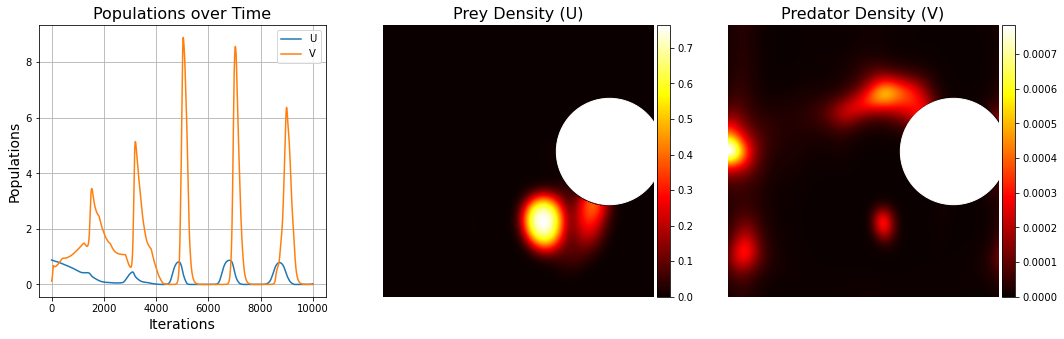

<Figure size 432x288 with 0 Axes>

In [180]:
make_fig(U, V,color='hot')

100%|██████████| 20000/20000 [07:01<00:00, 47.47it/s]


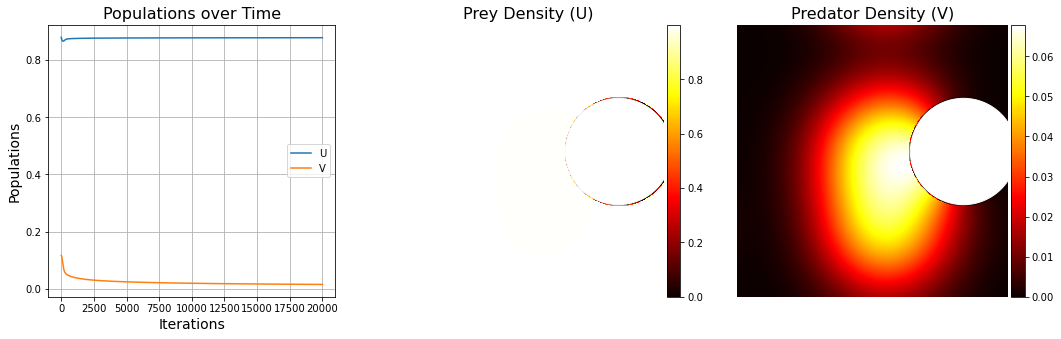

<Figure size 432x288 with 0 Axes>

In [185]:
N = 300
dx = 400/N
U, V, F, G, L_U, L_V = init_arrays(N)
D_U = 0.01
D_V = 1
alpha = 0.5
beta = 9
gamma = 0.9
dt = 0.05

output_dir = "data"
Nit = 20000
data_array = np.zeros((Nit, 2))

fps = 5
nSeconds = 20

# fig, axarr = plt.subplots(1,2)

# im_1 = axarr[0].imshow(U, interpolation='none')
# im_2 = axarr[1].imshow(V, interpolation='none')

# ims = [im_1, im_2]
# cbars = []
# for im in ims:
#     # Create colorbar
#     cbar = plt.colorbar(im)
#     cbars.append(cbar)


#anim = animation.FuncAnimation(fig, animate_func,frames = nSeconds * fps, interval = 1000/ fps, repeat=False)
#plt.show()

#print('starting save')

#anim.save(f'{output_dir}/N_{N}_Nit_{int(fps * nSeconds)}_a_{alpha}_b_{beta}_c_{gamma}_DU_{D_U}_DV_{D_V}_dt_{dt}.mp4', fps=fps)#, extra_args=['-vcodec', 'libx264'])

#print('Done!')
R, displacement_x, displacement_y = 60, 10,100
obj = get_circle(R, displacement_x, displacement_y)
nn, nn_numbers = get_neighbors(obj, U, V)
for i in tqdm(range(Nit)):
    do_iter_diffusion_object(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, nn, nn_numbers, data_array, i)
    

make_fig(U, V,color='hot')



In [189]:
a = np.linspace(0,1,11)
a,a/(1-a)

<ipython-input-189-de359f22c338>:2: RuntimeWarning: divide by zero encountered in true_divide
  a,a/(1-a)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.        , 0.11111111, 0.25      , 0.42857143, 0.66666667,
        1.        , 1.5       , 2.33333333, 4.        , 9.        ,
               inf]))

In [188]:
(1+a)/(1-a)

<ipython-input-188-3875b378b158>:1: RuntimeWarning: divide by zero encountered in true_divide
  (1+a)/(1-a)


array([ 1.        ,  1.22222222,  1.5       ,  1.85714286,  2.33333333,
        3.        ,  4.        ,  5.66666667,  9.        , 19.        ,
               inf])